In [1]:
%matplotlib inline

import numpy as np
import power_laws
import matplotlib.colors
import seaborn
import pandas as pd
import rubisco_data

from adjustText import adjust_text
from scipy import stats
from matplotlib import pyplot as plt

In [2]:
# Load the data from Excel, remove data points that are not comparable.
# raw_kin_df is everything in the file, kin_df is the subset with all relevant kinetic data.
raw_kin_df, kin_df = rubisco_data.load_rubisco_data()

# Subset the data in various ways for future use
raw_kin_df, savir_df, nonsavir_df = rubisco_data.filter_data(raw_kin_df)

# Group by RuBisCO form
grouped_form = raw_kin_df.groupby('isoform')

# Markers we use for plotting below.
markers = 'o><^dsphH*'

cnames = ["windows blue", "amber", "greyish brown", "dusty purple", "dusty teal", "dusty red", ]
named_colors = seaborn.xkcd_palette(cnames)

In [3]:
full_dataset = pd.read_csv('../data/DatasetS4_RubiscoKineticsFull_Merged.csv')

# Grab mutant data from the full dataset
mut_df = full_dataset[full_dataset.mutant == True]
mutF1_df = mut_df[mut_df.isoform == '1']
mutF2_df = mut_df[mut_df.isoform == '2']

In [4]:
deduped_mutF1_df = mutF1_df.copy()
print('shape before', deduped_mutF1_df.shape)

# Shih 2016 reproduces a lot of data from previous references. 
for key, gdf in mutF1_df.groupby('species'):
    if gdf.shape[0] < 2:
        continue
        
    shih = (gdf.short_ref == 'Shih 2016')
    deduped_mutF1_df.drop(gdf[shih].index, axis=0, inplace=True)

print('shape after', deduped_mutF1_df.shape)

shape before (56, 36)
shape after (43, 36)


In [5]:
print(deduped_mutF1_df.shape[0], 'mutant rubiscos')

mask = deduped_mutF1_df.kon_C.notnull() & deduped_mutF1_df.kon_O.notnull()
print(mask.sum(), 'with enough data')

43 mutant rubiscos
15 with enough data


In [6]:
F1_data = raw_kin_df[raw_kin_df.isoform == '1']
F2_data = raw_kin_df[raw_kin_df.isoform == '2']
F23_data = raw_kin_df[raw_kin_df.isoform == '2_3']

group_mapping = {'C3 plants': 'C3 plants',
                 'C3-C4 plants': 'C3-C4 plants',
                 'Cyanobacteria': 'Cyanobacteria',
                 'C4 plants': 'C4 plants',
                 'Green algae': 'Green algae',
                 'Red algae': 'Red algae',
                 'Alphaproteobacteria': 'Proteobacteria',
                 'Betaproteobacteria': 'Proteobacteria',
                 'Gammaproteobacteria': 'Proteobacteria',
                }
color_mapping = {
    'C3 plants': 'dusty green',
    'C3-C4 plants': 'very light brown',
    'C4 plants': 'pea soup',
    'Cyanobacteria': 'dark blue green',
    'Green algae': 'dusty teal',
    'Red algae': 'dusty red',
    'Proteobacteria': 'dusty rose',
    'Form II':  "amber", 
    'Form II/III': "greyish brown",
}

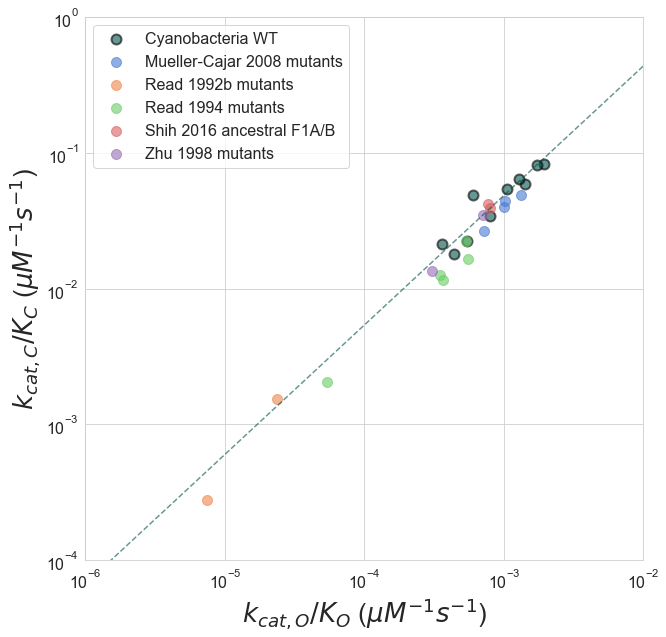

In [7]:
# Mutant data for cyanobacterial Rubiscos
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')
seaborn.set_palette('muted')

plt.xscale('log')
plt.yscale('log')

grouped_taxa = F1_data.set_index('taxonomy').groupby(group_mapping)

cyano_wt_df = F1_data[F1_data.taxonomy == 'Cyanobacteria']
mask = np.logical_and(cyano_wt_df.kon_C.notnull(), cyano_wt_df.kon_O.notnull())
exp, pre, rval = power_laws.fit_power_law_odr(np.log(cyano_wt_df[mask].kon_O), np.log(cyano_wt_df[mask].kon_C))
xs = np.logspace(-6, -2, 20)
ys = pre*np.power(xs, exp)

cname = color_mapping['Cyanobacteria']
c = seaborn.xkcd_rgb[cname]
plt.plot(xs, ys, ls='--', c=c, alpha=0.6)
label = 'Cyanobacteria WT'
plt.scatter(cyano_wt_df[mask].kon_O, cyano_wt_df[mask].kon_C, c=c, s=100,
            edgecolors='k', linewidths=2, label=label, alpha=0.6)

mask = deduped_mutF1_df.kon_O.notnull() & deduped_mutF1_df.kon_C.notnull()
muts_by_ref = deduped_mutF1_df[mask].groupby('short_ref')
for i, (group, gdf) in enumerate(muts_by_ref):
    label = '%s mutants' % group
    if group.startswith('Shih'):
        label = '%s ancestral F1A/B' % group
    plt.scatter(gdf.kon_O, gdf.kon_C, s=100, label=label, alpha=0.6)

plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$k_{cat,O} / K_O$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.ylabel('$k_{cat,C} / K_C$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(1e-6, 1e-2)
plt.ylim(1e-4, 1)

plt.show()

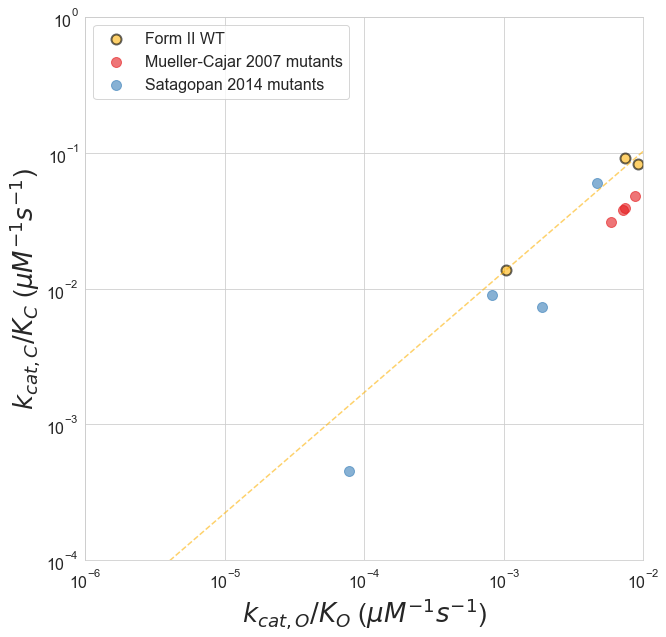

In [8]:
# Mutant data for form II rubiscos
figure = plt.figure(figsize=(10,10))
seaborn.set_style('whitegrid')
seaborn.set_palette('Set1')

plt.xscale('log')
plt.yscale('log')

mask = np.logical_and(F2_data.kon_C.notnull(), F2_data.kon_O.notnull())
exp, pre, rval = power_laws.fit_power_law_odr(np.log(F2_data[mask].kon_O), np.log(F2_data[mask].kon_C))
xs = np.logspace(-6, -2, 20)
ys = pre*np.power(xs, exp)

cname = color_mapping['Form II']
c = seaborn.xkcd_rgb[cname]
plt.plot(xs, ys, ls='--', c=c, alpha=0.6)
label = 'Form II WT'
plt.scatter(F2_data[mask].kon_O, F2_data[mask].kon_C, c=c, s=100,
            edgecolors='k', linewidths=2, label=label, alpha=0.6)

mask = mutF2_df.kon_O.notnull() & mutF2_df.kon_C.notnull()
muts_by_ref = mutF2_df[mask].groupby('short_ref')
for i, (group, gdf) in enumerate(muts_by_ref):
    label = '%s mutants' % group
    plt.scatter(gdf.kon_O, gdf.kon_C, s=100, label=label, alpha=0.6)

plt.legend(loc=2, fontsize=16, frameon=True)
plt.xlabel('$k_{cat,O} / K_O$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.ylabel('$k_{cat,C} / K_C$ ($\mu M^{-1} s^{-1}$)', fontsize=26)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.xlim(1e-6, 1e-2)
plt.ylim(1e-4, 1)

plt.show()